In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import random 

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# CONFIG

**Set sample to False if you want to run algos on entire dataset**

In [ ]:
CONFIG = {
    'sample': True,
    'sample_months': 1, # how many months to sample (for development)
    'top_n_clusters': 2, # how many clusters to train
    'random_state': 123,
    'target_col': 'delta',
    'n_jobs': 4,  # gridsearch parallelization, might need to adjust based on your system
    'ts_splits': 5, # TimeSeriesSplit number of splits
    'ts_gap': 48,  # 2-day gap
    'visualize_clusters': False
}

FEATURE_COLS = {
    'categorical': ['isHoliday', 'has_kiosk', 'weather_cluster', 'workhours', 'commute', 'free', 'night'],
    'drop': ['weather_code', 'timestamp', 'station_name', 'arrivals', 'departures', 'num_docks_available', 'num_ebikes_available', 'capacity', 'cluster', 'sunset', 'sunrise', 'year', 'day', 'hour_extract'],
    'time': ['weekday', 'month', 'hour']
}

# DATA LOADING

In [21]:
df = pd.read_parquet("data/final/df.parquet")

In [22]:
print(df.shape)

(6464880, 94)


In [23]:
# REDUCE DATASET SIZE FOR DEVELOPMENT
if CONFIG['sample']:
    months = df['timestamp'].dt.month.unique()
    random_month = random.sample(list(months), CONFIG['sample_months'])
    df = df[df['timestamp'].dt.month.isin(random_month)]
    print(f'Sampled {CONFIG["sample_months"]} month(s): {random_month}')

Sampled 1 month(s): [np.int32(8)]


In [24]:
df.head()

,station_name,hour,departures,arrivals,hour_extract,temperature_2m,weather_code,rain,precipitation,snowfall,...,var_sum_station_nonnight,avg_sum_station_holiday,var_sum_station_holiday,avg_sum_station_commute,var_sum_station_commute,avg_sum_station_free,var_sum_station_free,avg_sum_station_unfriendly_weather,var_sum_station_unfriendly_weather,cluster
5088,10th & E St NW,0,0.0,0.0,0,20.835999,0.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5
5089,10th & E St NW,1,0.0,0.0,1,20.785999,0.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5
5090,10th & E St NW,2,0.0,0.0,2,20.035999,0.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5
5091,10th & E St NW,3,0.0,0.0,3,19.236000,1.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5
5092,10th & E St NW,4,0.0,0.0,4,18.935999,1.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5


In [25]:
# All remaining columns are considered numerical
FEATURE_COLS['numerical'] = [col for col in df.columns if col not in [CONFIG['target_col']] + FEATURE_COLS['categorical'] + FEATURE_COLS['drop'] + FEATURE_COLS['time']]

In [26]:
# Sanity check
FEATURE_COLS['numerical']

['temperature_2m',
 'rain',
 'precipitation',
 'snowfall',
 'cloud_cover',
 'wind_gusts_10m',
 'wind_speed_10m',
 'num_bikes_available',
 'latitude',
 'longitude',
 'dayofweek',
 'dayofyear',
 'var_delta_station_total',
 'avg_delta_station_total',
 'avg_arrivals_station_total',
 'avg_departures_station_total',
 'var_arrivals_station_total',
 'var_departures_station_total',
 'avg_delta_station_night',
 'var_delta_station_night',
 'avg_arrivals_station_night',
 'var_arrivals_station_night',
 'avg_departures_station_night',
 'var_departures_station_night',
 'avg_delta_station_nonnight',
 'var_delta_station_nonnight',
 'avg_arrivals_station_nonnight',
 'var_arrivals_station_nonnight',
 'avg_departures_station_nonnight',
 'var_departures_station_nonnight',
 'avg_delta_station_holiday',
 'var_delta_station_holiday',
 'avg_arrivals_station_holiday',
 'var_arrivals_station_holiday',
 'avg_departures_station_holiday',
 'var_departures_station_holiday',
 'avg_delta_station_commute',
 'var_delta_

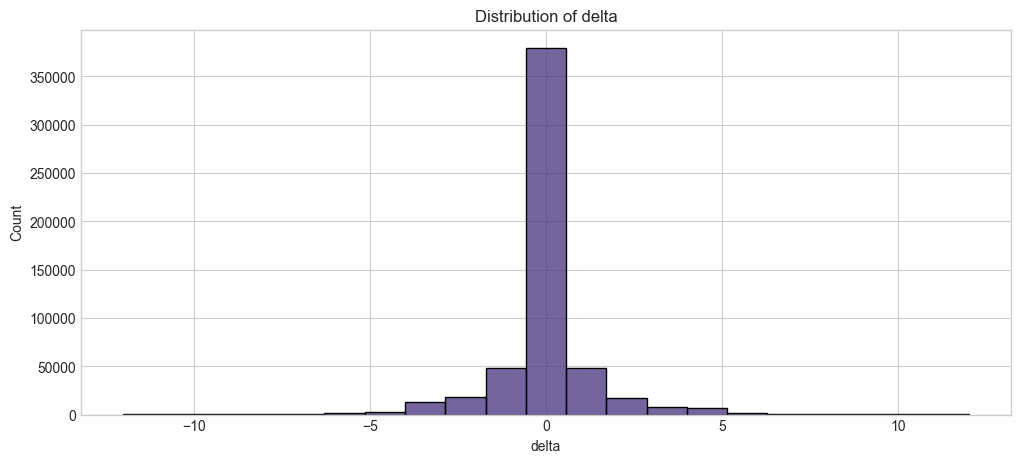

In [27]:
# Distribution of the target variable

plt.figure(figsize=(12, 5))
sns.histplot(df[CONFIG['target_col']], binrange=(-12, 12))
plt.title(f'Distribution of {CONFIG["target_col"]}')
plt.show()

# Time series plot of the target
# Takes a while to run
# plt.figure(figsize=(15, 6))
# df_processed.set_index('datetime')[CONFIG['target_col']].plot()
# plt.title(f'{CONFIG["target_col"]} Over Time')
# plt.tight_layout()
# plt.show()

## Data preparation

In [28]:
df.columns

Index(['station_name', 'hour', 'departures', 'arrivals', 'hour_extract',
       'temperature_2m', 'weather_code', 'rain', 'precipitation', 'snowfall',
       'cloud_cover', 'wind_gusts_10m', 'wind_speed_10m', 'sunrise', 'sunset',
       'weather_cluster', 'num_docks_available', 'num_bikes_available',
       'num_ebikes_available', 'has_kiosk', 'capacity', 'latitude',
       'longitude', 'isHoliday', 'weekday', 'night', 'workhours', 'commute',
       'free', 'day', 'month', 'year', 'dayofweek', 'dayofyear', 'timestamp',
       'delta', 'var_delta_station_total', 'avg_delta_station_total',
       'avg_arrivals_station_total', 'avg_departures_station_total',
       'var_arrivals_station_total', 'var_departures_station_total',
       'avg_delta_station_night', 'var_delta_station_night',
       'avg_arrivals_station_night', 'var_arrivals_station_night',
       'avg_departures_station_night', 'var_departures_station_night',
       'avg_delta_station_nonnight', 'var_delta_station_nonnight',
 

In [29]:
# Prepare data for modeling
def prepare_data(df, target_col, categorical_cols, numerical_cols, time_cols, drop_cols):
    # Drop rows with NaN
    df_clean = df.dropna()
    # Drop rows with zero target
    print(f"Dropped {len(df) - len(df_clean)} rows with NaN values.")
    
    # Keep datetime for reference
    datetime_col = df_clean['datetime'] if 'datetime' in df_clean.columns else None
    
    # Drop columns defined above
    df_clean = df_clean.drop(columns=drop_cols, errors='ignore')
    
    # Split features and target
    X = df_clean[categorical_cols + numerical_cols + time_cols]
    y = df_clean[target_col]
    
    return X, y, datetime_col

# Test-apply data preparation
X, y, datetime_col = prepare_data(df, CONFIG['target_col'], FEATURE_COLS['categorical'], FEATURE_COLS['numerical'], FEATURE_COLS['time'], FEATURE_COLS['drop'])

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
X.head()

Dropped 0 rows with NaN values.
Features shape: (549072, 79)
Target shape: (549072,)


,isHoliday,has_kiosk,weather_cluster,workhours,commute,free,night,temperature_2m,rain,precipitation,...,var_sum_station_holiday,avg_sum_station_commute,var_sum_station_commute,avg_sum_station_free,var_sum_station_free,avg_sum_station_unfriendly_weather,var_sum_station_unfriendly_weather,weekday,month,hour
5088,False,YES,clear_and_cloudy,False,False,False,True,20.835999,0.0,0.0,...,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,1,8,0
5089,False,YES,clear_and_cloudy,False,False,False,True,20.785999,0.0,0.0,...,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,1,8,1
5090,False,YES,clear_and_cloudy,False,False,False,True,20.035999,0.0,0.0,...,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,1,8,2
5091,False,YES,clear_and_cloudy,False,False,False,True,19.236000,0.0,0.0,...,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,1,8,3
5092,False,YES,clear_and_cloudy,False,False,False,True,18.935999,0.0,0.0,...,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,1,8,4


## Modeling
### Pipelines

In [30]:
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

# Function to create model pipelines for each cluster
def create_model_pipelines(categorical_cols, numerical_cols, time_cols):
    
    preprocessor_plain = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ], remainder='passthrough')
    
    preprocessor_onehot = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('time', OneHotEncoder(handle_unknown='ignore', sparse_output=False), time_cols),
    ], remainder='passthrough')
    
    # Prepared but currently not in use
    preprocessor_sincos = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('sin_month', sin_transformer(12), ['month']),
        ('sin_hour', sin_transformer(24), ['hour']),
        ('sin_weekday', sin_transformer(7), ['weekday']),
        ('cos_month', cos_transformer(12), ['month']),
        ('cos_hour', cos_transformer(24), ['hour']),
        ('cos_weekday', cos_transformer(7), ['weekday'])
    ], remainder='passthrough')
    
    # Create pipelines
    pipelines = {
        'linear': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', LinearRegression())
        ]),
  
        'decision_tree': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', DecisionTreeRegressor(random_state=CONFIG['random_state']))
        ]),
        'random_forest': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', RandomForestRegressor(random_state=CONFIG['random_state']))
        ]),
        'xgboost': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=CONFIG['random_state']))
        ]),
        'gbm': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', GradientBoostingRegressor(random_state=CONFIG['random_state']))
        ])
    }
    
    # Store preprocessor strategies
    preprocessing_strategies = {
        'plain': preprocessor_plain,
        'onehot': preprocessor_onehot,
        'sincos': preprocessor_sincos
    }
    
    preprocessor_plain.strategy_name = 'Plain'
    preprocessor_onehot.strategy_name = 'OneHot'  
    preprocessor_sincos.strategy_name = 'SinCos'
    
    return pipelines, preprocessing_strategies

# Function to get parameter grids
def get_param_grids(preprocessing_strategies):
    return {
        'linear': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ]
            },
        
        'decision_tree': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__max_depth': [10, 20],
            'regressor__min_samples_split': [2, 5, 10, 15, 20]
        },
        
        'random_forest': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__n_estimators': [50, 100],
            'regressor__max_depth': [10, 20],
            'regressor__min_samples_split': [2, 5]
        },
        
        'xgboost': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__n_estimators': [50, 100],
            'regressor__max_depth': [3, 6],
            'regressor__learning_rate': [0.01, 0.1]
        },
        
        'gbm': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__n_estimators': [50, 100],
            'regressor__max_depth': [3, 6],
            'regressor__learning_rate': [0.01, 0.1]
        }
    }

In [31]:
# Function to plot feature importance
def plot_feature_importance(model_name, model, X):
    # Only for tree-based models
    if not hasattr(model[-1], 'feature_importances_'):
        print(f"Model {model_name} doesn't support feature importance.")
        return
    
    # Get feature names after preprocessing
    if hasattr(model[0], 'get_feature_names_out'):
        # For newer scikit-learn versions
        feature_names = model[0].get_feature_names_out()
    else:
        # Fallback for when feature names aren't available
        feature_names = [f"feature_{i}" for i in range(X.shape[1])]
    
    # Extract feature importances
    importance = model[-1].feature_importances_
    
    # Create DataFrame for better visualization
    feature_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
    plt.title(f'Feature Importance - {model_name}')
    plt.tight_layout()
    plt.show()
    
    return feature_imp

In [32]:
# Function to make and visualize predictions
def visualize_predictions(model_name, model, X, y, datetime_col):
    # Make predictions
    y_pred = model.predict(X)
    
    # Create a DataFrame for plotting
    pred_df = pd.DataFrame({
        'datetime': datetime_col,
        'actual': y,
        'predicted': y_pred
    })
    
    # Calculate metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Plot actual vs predicted
    plt.figure(figsize=(15, 6))
    plt.plot(pred_df['datetime'], pred_df['actual'], label='Actual', alpha=0.7)
    plt.plot(pred_df['datetime'], pred_df['predicted'], label='Predicted', alpha=0.7)
    plt.title(f'{model_name} - Actual vs Predicted (MSE: {mse:.2f}, R²: {r2:.2f})')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot residuals
    pred_df['residual'] = pred_df['actual'] - pred_df['predicted']
    
    plt.figure(figsize=(15, 6))
    plt.scatter(pred_df['predicted'], pred_df['residual'], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title(f'{model_name} - Residuals Plot')
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.tight_layout()
    plt.show()
    
    return pred_df

### Train

In [33]:
# Function to train and evaluate a single model
def train_evaluate_model(name, pipeline, param_grid, X, y, n_splits=CONFIG['ts_splits']):
    print(f"\nTraining {name} model...")
    
    # Use TimeSeriesSplit for validation
    tscv = TimeSeriesSplit(
        n_splits=n_splits,
        gap=CONFIG['ts_gap'])
    
    # GridSearch with time series split
    grid_search = GridSearchCV(
        pipeline, 
        param_grid,
        cv=tscv, 
        scoring='neg_mean_squared_error',
        n_jobs=CONFIG['n_jobs'],
        verbose=1,
        return_train_score=True,
    )
    
    grid_search.fit(X, y)
    
    best_params = grid_search.best_params_
    if 'preprocessing' in best_params.keys():
        if hasattr(best_params['preprocessing'], 'strategy_name'):
            preproc_name = best_params['preprocessing'].strategy_name
    else:
        preproc_name = 'Unknown'
    
    # Store results
    best_model = grid_search.best_estimator_
    mean_train_score = -grid_search.cv_results_['mean_train_score']
    result = {
        'best_params': grid_search.best_params_,
        'best_score': -grid_search.best_score_,  # Convert back to positive MSE
        'rmse': np.sqrt(-grid_search.best_score_),
        'mean_train_score': np.mean(mean_train_score),
    }
    
    print(f"  Best parameters: {grid_search.best_params_}")
    print(f"  Preprocessing strategy: {preproc_name}")
    print(f"  MSE: {-grid_search.best_score_:.4f}")
    print(f"  RMSE: {np.sqrt(-grid_search.best_score_):.4f}")
    print(f"  Mean Train Score: {np.mean(mean_train_score)}")
    
    return best_model, result

In [34]:
def prepare_cluster_data(cluster_id, df_processed):

    cluster_df = df_processed[df_processed['cluster'] == cluster_id].copy()
    return prepare_data(cluster_df, CONFIG['target_col'], FEATURE_COLS['categorical'], FEATURE_COLS['numerical'], FEATURE_COLS['time'], FEATURE_COLS['drop'])

def train_cluster_models(X, y, models_to_train):

    best_models = {}
    results = {}
    
    pipelines, preprocessing_strategies = create_model_pipelines(FEATURE_COLS['categorical'], FEATURE_COLS['numerical'], FEATURE_COLS['time'])
    param_grids = get_param_grids(preprocessing_strategies)
    
    for model_name in models_to_train:
        if model_name in pipelines:
            best_models[model_name], results[model_name] = train_evaluate_model(
                model_name, pipelines[model_name], param_grids[model_name], X, y
            )
    
    return best_models, results

def create_comparison_df(results_dict):

    comparison = pd.DataFrame({
        'Model': list(results_dict.keys()),
        'RMSE': [results_dict[m]['rmse'] for m in results_dict.keys()]
    }).sort_values('RMSE')
    
    return comparison

In [35]:
# Store cluster results
all_cluster_models = {}
all_cluster_results = {}
all_cluster_comparisons = {}

# Function to train models for a single cluster
def train_models_for_cluster(cluster_id, df_processed, models_to_train):
    # Print heading
    print(f"\n{'='*50}")
    print(f"Training models for Cluster {cluster_id}")
    print(f"{'='*50}")
    
    # Get data for this cluster
    X_cluster, y_cluster, datetime_col_cluster = prepare_cluster_data(cluster_id, df_processed)
    print(f"Cluster size: {len(X_cluster)} records")
    
    # Train models
    best_models_cluster, results_cluster = train_cluster_models(X_cluster, y_cluster, models_to_train)
    
    # Compare models for this cluster
    comparison_cluster = pd.DataFrame({
        'Model': list(results_cluster.keys()),
        'RMSE': [results_cluster[m]['rmse'] for m in results_cluster.keys()]
    }).sort_values('RMSE')
    
    print(f"\nModel Comparison for Cluster {cluster_id}:")
    print(comparison_cluster)
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='RMSE', y='Model', data=comparison_cluster)
    plt.title(f'Cluster {cluster_id} - Model Comparison (RMSE - lower is better)')
    plt.tight_layout()
    plt.show()
    
    # Show feature importance for tree-based models
    # for model_name in ['random_forest', 'xgboost', 'gbm']:
    #     if model_name in best_models_cluster:
    #         print(f"\nFeature Importance for {model_name} in Cluster {cluster_id}:")
    #         feature_imp = plot_feature_importance(model_name, best_models_cluster[model_name], X_cluster)
    
    # Visualize best model predictions
    best_model_name = comparison_cluster['Model'].iloc[0]
    print(f"Best model for Cluster {cluster_id}: {best_model_name} with RMSE: {comparison_cluster['RMSE'].iloc[0]:.4f}")
    
    # if best_model_name in best_models_cluster:
    #     pred_df = visualize_predictions(
    #         f"{best_model_name} (Cluster {cluster_id})", 
    #         best_models_cluster[best_model_name], 
    #         X_cluster, y_cluster, datetime_col_cluster
    #     )
    
    return best_models_cluster, results_cluster, comparison_cluster

In [ ]:
models_to_train = ['linear', 'decision_tree', 'xgboost']#, 'random_forest']

# Get unique clusters
unique_clusters = sorted(df['cluster'].unique())
print(f"Found {len(unique_clusters)} clusters: {unique_clusters}")

# Train models for each cluster
for i, cluster_id in enumerate(unique_clusters):
    print(f"\n{'='*50}\nProcessing Cluster {cluster_id}\n{'='*50}")
    
    # Get data for this cluster
    X_cluster, y_cluster, datetime_col = prepare_cluster_data(cluster_id, df)
    print(f"Cluster size: {len(X_cluster)} records")
    
    # Train models
    models, results = train_cluster_models(X_cluster, y_cluster, models_to_train)
    
    # Store results
    all_cluster_models[cluster_id] = models
    all_cluster_results[cluster_id] = results
    all_cluster_comparisons[cluster_id] = create_comparison_df(results)
    
    if i == CONFIG['top_n_clusters']:
        break

Found 10 clusters: [5 0 1 3 4 7 8 6 2 9]

Processing Cluster 5
Dropped 0 rows with NaN values.
Cluster size: 32736 records

Training linear model...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
  Best parameters: {'preprocessing': ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['temperature_2m', 'rain', 'precipitation',
                                  'snowfall', 'cloud_cover', 'wind_gusts_10m',
                                  'wind_speed_10m', 'num_bikes_available',
                                  'latitude', 'longitude', 'dayofweek',
                                  'dayofyear', 'var_delta_station_total',
                                  'avg_delta_station_total',
                                  'avg_arrivals_station_total',
                                  'avg_departures_stat...
                                  'var_arrivals_station_nonnight',
                          

In [37]:
# Visualize results
if CONFIG['visualize_clusters']:
    visualize_cluster_results(cluster_id, models, X_cluster, y_cluster) # TODO


Best Models by Cluster:
   Cluster Best Model      RMSE
8        2    xgboost  0.516767
6        8    xgboost  0.557756
9        9    xgboost  0.667810
3        3    xgboost  0.843791
2        1    xgboost  1.068478
1        0    xgboost  1.930823
0        5    xgboost  2.154841
5        7    xgboost  2.328872
7        6    xgboost  2.632099
4        4    xgboost  2.794944


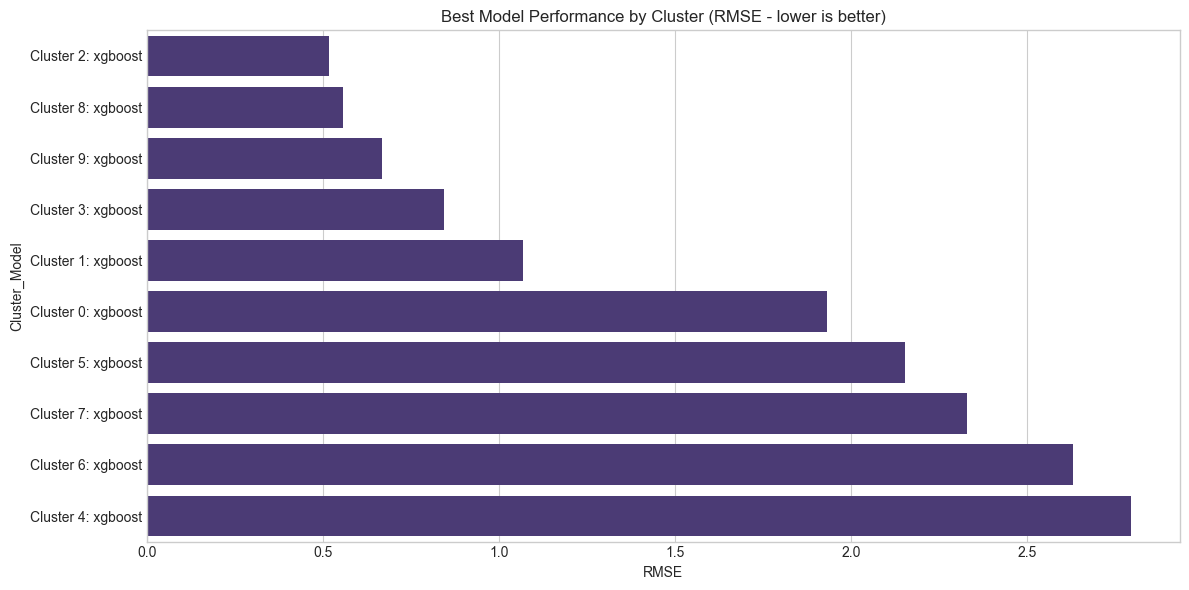

In [38]:
# Create a summary of best models across clusters
summary_rows = []
for cluster_id in all_cluster_comparisons:
    best_model = all_cluster_comparisons[cluster_id].iloc[0]
    summary_rows.append({
        'Cluster': cluster_id,
        'Best Model': best_model['Model'],
        'RMSE': best_model['RMSE'],
    })

cluster_summary = pd.DataFrame(summary_rows).sort_values('RMSE')

print("\nBest Models by Cluster:")
print(cluster_summary)

# Plot cluster performance comparison
plt.figure(figsize=(12, 6))
cluster_summary_plot = cluster_summary.copy()
cluster_summary_plot['Cluster_Model'] = cluster_summary_plot.apply(
    lambda x: f"Cluster {x['Cluster']}: {x['Best Model']}", axis=1
)
sns.barplot(x='RMSE', y='Cluster_Model', data=cluster_summary_plot)
plt.title('Best Model Performance by Cluster (RMSE - lower is better)')
plt.tight_layout()
plt.show()